# Notebook to make Taylor diagrams

In [3]:
!pip install git+https://github.com/raphaeldussin/easy_coloc.git

  Cloning https://github.com/raphaeldussin/easy_coloc.git to /tmp/pip-req-build-9unhlnqc
  Running command git clone -q https://github.com/raphaeldussin/easy_coloc.git /tmp/pip-req-build-9unhlnqc
  Created wheel for easy-coloc: filename=easy_coloc-1.2-cp37-none-any.whl size=15236 sha256=5f75cff00bb13aece4cebbd372c233bbf95beac054392282923ff74495f8db85
  Stored in directory: /tmp/pip-ephem-wheel-cache-wrfo65nr/wheels/d2/7d/b4/b59fd9036952a1fd5fd53be0197d0765da76ff584b04961e7d
Successfully built easy-coloc


In [85]:
# Make other folders visible
import sys
import intake
import dateutil
import datetime
import xarray as xr
import pandas as pd
import numpy as np

# Plotting stuff
import matplotlib.pylab as plt
import cartopy as cart
from matplotlib import cm
import cmocean

# custom from utils folder
sys.path.insert(1, '/home/jovyan/CMIP6_OceanAtlas/utils')
from taylor_diagram import TaylorDiagram
#import generate_model_sections
import get_stats

import xarray as xr
import pandas as pd
import cartopy as cart
import matplotlib.pylab as plt
from matplotlib import cm
import datetime
import cmocean
import numpy as np
import dateutil

In [43]:
def regridder(model,obs,ovar_name):

    bgc_ovar_names = ['dissic','no3','po4','talk']

    # z distance is much less than distance between stations
    scale_factor = model.dx.mean().values*1e3

    ovar_obs = obs.iloc[0:,2].values.ravel()
    
    stations_obs = obs.station.values.ravel()
    depth_obs = obs.depth.values.ravel()


    stations_model = model.station.values.ravel()
    depth_model = model.lev.values.ravel()

    stations_model,depth_model = np.meshgrid(stations_model,depth_model)

    interpolated_obs = scint.griddata((stations_obs, depth_obs/scale_factor),ovar_obs,
                              (stations_model, depth_model/scale_factor),
                              method='linear')

    interpolated_obs = xr.DataArray(interpolated_obs,dims = model.dims, coords = model.coords,attrs=model[ovar_name].attrs)
    interpolated_obs = interpolated_obs.where(~np.isnan(model[ovar_name]))
    interpolated_obs = interpolated_obs.to_dataset(name=ovar_name)
    
    return interpolated_obs


def glodap_to_model(cruise_id,glodap,coords,ovar_name):
    
    expocode=expc[expc.ID==cruise_id].EXPOCODE.values[0]
    section_obs = glodap[glodap.cruise==cruise_id]
    station_obs = coords[coords.cruise==cruise_id]['station'] # get the station numbers for this particular cruise
    

    section_model = xr.open_mfdataset(f'../../../sections/{ovar_name}_{model}_r*_{expocode}.nc')
    section_obs = section_obs[section_obs.station.isin(station_obs)]
    section_model['station'] = station_obs.values # replace global station index with one for this cruise

    section_obs = section_obs[['station','depth',model2glodap_ovar_name[ovar_name]]] # grab ovar_name from the section
    section_obs[section_obs==-9999]= np.NaN # station_obs must have -9999 replaced with nans
    section_obs = section_obs.dropna()
    
    # If there are no obs of this variable, section_obs will be empty.
    # Here we make sure this cruise has observations of this variable before interpolation
    if len(section_obs) > 0:

        obs = section_obs[['station','depth',model2glodap_ovar_name[ovar_name]]].dropna()
        model_output = section_model

        interpolated_obs = regridder(model_output,obs,ovar_name)

        interpolated_obs.to_netcdf(f'../../../sections/{ovar_name}_{model}_OBSERVED_{expocode}.nc')

# Model to line

In [38]:
model_dict=['CanESM5', 'MIROC', 'UKESM']
ovar_dict = ['thetao', 'so']

In [41]:
from easy_coloc import lib_easy_coloc
import xarray as xr
import pandas as pd
import cartopy as cart
import matplotlib.pylab as plt
from matplotlib import cm
import datetime
import cmocean
import numpy as np
import dateutil
import intake
import dask

def model_to_line(ovar_name=None, 
                 model=None, 
                 cruise_line=None,
                 catalog_path='../catalogs/pangeo-cmip6.json',
                 qc_path='../qc'):
    '''
    generate_model_section(ovar_name, model)

    ** THIS IS SLOW **
    
    Input
    ==========
    ovar_name : variable name (eg 'dissic')
    model : model name (eg CanESM5)
    
    Output
    ===========
    ds : dataset of section output
    
    Example
    ============
    ds = model_to_line(ovar_name='dissic', 
                   model='CanESM5', 
                   cruise_line='A16')
    '''
    institue = {'CanESM5':'CCCma',
                'CNRM-ESM2-1':'CNRM-CERFACS',
                'IPSL-CM6A-LR':'IPSL',
                'MIROC-ES2L':'MIROC',
                'UKESM1-0-LL':'MOHC',
                'GISS-E2-1-G-CC':'NASA-GISS',
                'GISS-E2-1-G':'NASA-GISS'
               }

    # Get CMIP6 output from intake_esm
    col = intake.open_esm_datastore(catalog_path)
    cat = col.search(experiment_id='historical', 
                     table_id='Omon', 
                     variable_id=ovar_name, 
                     grid_label='gn')

    # dictionary of subset data
    dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                    cdf_kwargs={'chunks': {}})

    # Put data into dataset
    ds = dset_dict[f'CMIP.{institue[model]}.{model}.historical.Omon.gn']

    
    # Rename olevel to lev 
    coord_dict = {'olevel':'lev'} # a dictionary for converting coordinate names
    if 'olevel' in ds.dims:
        ds = ds.rename(coord_dict)

    # load GLODAP station information from csv file
    # drop nans, reset index, and drop uneeded variable
    df = pd.read_csv(f'{qc_path}/GLODAPv2.2019_COORDS.csv')
    df = df.dropna()
    df = df.reset_index().drop('Unnamed: 0', axis=1)

    # Genearte times list and put into dataframe
    times = [f'{int(year)}-{int(month):02d}-01' for year,month in zip(df.year,df.month)]
    df['dates'] = times 

    # Find unique dates, these are the sample dates
    sample_dates = df['dates'].sort_values().unique()
    
    # Parse the historical period
    sample_dates = sample_dates[0:125]
    sample_dates = [dateutil.parser.parse(date) for date in sample_dates]

    # shift dates to middle of the month
    ds['time'] = pd.date_range(start=f'{ds.time.dt.year[0].values}-{ds.time.dt.month[0].values:02}',
                               end=f'{ds.time.dt.year[-1].values}-{ds.time.dt.month[-1].values:02}',
                               freq='MS')

    # ==========================================
    # Here we start making the ovar dataset
    # ==========================================
    # Trim the dates to sample_dates
    ovar = ds[ovar_name].sel(time=sample_dates)
    ovar['lat'] = ds.latitude
    ovar['lon'] = ds.longitude

    # create source grid and target section objects
    # this requires lon,lat from stations and the source grid dataset containing lon,lat
    proj = lib_easy_coloc.projection(df['longitude'].values,df['latitude'].values,grid=ovar,
                                     from_global=True)

    # 4-D max for easy_coloc. Not entirely sure what we are squeezing out?
    ovar = ovar.squeeze() 

    # run the projection on the WOA analyzed temperature (t_an)
    fld = np.zeros((len(sample_dates),len(ovar.lev),len(df)))

    # 
    for ind in range(5, 130, 5):
        dates = sample_dates[ind-5:ind]
        fld_tem = proj.run(ovar.sel(time=dates)[:])
        fld[ind-5:ind,:,:] = fld_tem

    # create datarray with sampling information
    sampled_var = xr.DataArray(fld,
                               dims=['time','lev','all_stations'],
                               coords={'time':ovar['time'],
                                       'lev':ovar['lev'],
                                       'all_stations':df.index.values,
                                       'dx':('all_stations',df.dx.values),
                                       'bearing':('all_stations',df.bearing.values),
                                       'lat':('all_stations',df.latitude.values),
                                       'lon':('all_stations',df.longitude.values),
                                      },
                               attrs={'units':ovar.units,
                                      'long_name':ovar.long_name
                                     }
                              )

    # Glodap expo codes
    expc = pd.read_csv(f'{qc_path}/FILTERED_GLODAP_EXPOCODE.csv')

    # rename df to coords
    cruise_x = df[df.cruise.isin( expc['ID'][expc.LINE.str.contains(cruise_line )] )]

    # need to change the Timedelta each day for some reason
    section_dates = [dateutil.parser.parse(date) for date in cruise_x.dates]
    
    section_dates = xr.DataArray(section_dates,dims='station')

    stations = cruise_x.index
    stations = xr.DataArray(stations,dims='station')

    section = sampled_var.sel(all_stations = stations, time=section_dates)
    #section.attrs['expocode'] = expc[expc.ID == cruise_id].EXPOCODE.values[0]
    section.name = ovar.name
    
    
    # convert datarray to dataset
    ds_out = section.to_dataset(name=ovar_name)

    return ds_out

In [42]:
ds = model_to_line(ovar_name='thetao', 
                   model='CanESM5', 
                   cruise_line='A01W OVIDE')

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 23 group(s)


In [19]:
#ds = ds.to_dataset(name='dissic')

In [25]:
#ds

<xarray.Dataset>
Dimensions:       (lev: 45, station: 292)
Coordinates:
    time          (station) datetime64[ns] 1990-04-01 1990-04-01 ... 2014-01-01
  * lev           (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
    all_stations  (station) int64 6661 6662 6663 6664 ... 8218 8219 8220 8221
    dx            (station) float64 0.0 67.31 837.2 6.665 ... 55.39 55.82 56.94
    bearing       (station) float64 0.0 169.4 -179.2 ... -179.7 -179.7 -178.7
    lat           (station) float64 41.15 40.55 33.02 ... -59.0 -59.5 -60.01
    lon           (station) float64 -19.99 -20.13 -20.0 ... -30.92 -30.92 -30.9
  * station       (station) int64 6661 6662 6663 6664 ... 8218 8219 8220 8221
Data variables:
    dissic        (station, lev) float64 2.152 2.152 2.152 2.152 ... nan nan nan

In [24]:
ds['time']

<xarray.DataArray 'time' (station: 292)>
array(['1990-04-01T00:00:00.000000000', '1990-04-01T00:00:00.000000000',
       '1990-04-01T00:00:00.000000000', ..., '2014-01-01T00:00:00.000000000',
       '2014-01-01T00:00:00.000000000', '2014-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    time          (station) datetime64[ns] 1990-04-01 1990-04-01 ... 2014-01-01
    all_stations  (station) int64 6661 6662 6663 6664 ... 8218 8219 8220 8221
    dx            (station) float64 0.0 67.31 837.2 6.665 ... 55.39 55.82 56.94
    bearing       (station) float64 0.0 169.4 -179.2 ... -179.7 -179.7 -178.7
    lat           (station) float64 41.15 40.55 33.02 ... -59.0 -59.5 -60.01
    lon           (station) float64 -19.99 -20.13 -20.0 ... -30.92 -30.92 -30.9
  * station       (station) int64 6661 6662 6663 6664 ... 8218 8219 8220 8221

# Load data

In [33]:
def get_stats(dict_params=None):
    '''
    get_stats(ds_obs, ds_mod, var)
    make a dictionary of statistics 
    
    Input
    =========
    ds_obs : xarray datarray of model
    ds_mod : xarray datarray of obs
    var : variable name you are looking at
    
    Output
    ==========
    stats_dict : dictionary of statistics comparing model and obsrvations 
    
    '''
    # get variable and model name
    var = dict_params['ovar']
    model = dict_params['model']
    
    # get model and obs dataarrays
    ds_mod = dict_params['ds_mod']
    ds_obs = dict_params['ds_obs']
    
    # rename variable to differentiatte obs and model
    ds_obs = ds_obs.rename({f'{var}': f'{var}_obs'})
    ds_mod = ds_mod.rename({f'{var}': f'{var}_mod'})

    # merge xarray datasets
    ds_merge = ds_obs.merge(ds_mod)

    # make a dataframe and drop nans
    ds_merge_nonan = ds_merge.to_dataframe().dropna()

    # Calculate various statistics 
    bias = ds_merge_nonan[f'{var}_mod'].mean() - ds_merge_nonan[f'{var}_obs'].mean()
    rmse = ((ds_merge_nonan[f'{var}_obs'] - ds_merge_nonan[f'{var}_mod']) ** 2).mean() ** .5
    aae = np.abs(ds_merge_nonan[f'{var}_obs'] - ds_merge_nonan[f'{var}_mod']).mean()
    corr = ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].corr(method='pearson').iloc[0,1]
    std_obs = ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].std()[f'{var}_obs']
    std_mod = ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].std()[f'{var}_mod']
    std_norm = ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].std()[f'{var}_mod'] /\
               ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].std()[f'{var}_obs']

    # Put stats in dictionary
    stats_dict = {'ovar': var,
                 'model': model,
                 #'member': member,
                 #'section': section,
                 'corr': corr,
                 'std_obs' : std_obs,
                 'std_mod': std_mod, 
                 'std_norm': std_norm,
                 'rmse': rmse, 
                 'bias': bias}

    return stats_dict

In [45]:
ds

<xarray.Dataset>
Dimensions:       (lev: 45, station: 76)
Coordinates:
    time          (station) datetime64[ns] 2014-05-01 2014-05-01 ... 2014-06-01
  * lev           (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
    all_stations  (station) int64 8722 8723 8724 8725 ... 8794 8795 8796 8797
    dx            (station) float64 0.0 48.82 15.51 10.51 ... 59.2 109.4 215.6
    bearing       (station) float64 0.0 -89.81 89.94 89.96 ... 122.2 -58.9 120.3
    lat           (station) float64 40.33 40.33 40.33 40.33 ... 52.5 53.0 51.99
    lon           (station) float64 -10.04 -9.46 -9.643 ... -52.5 -51.1 -53.82
  * station       (station) int64 8722 8723 8724 8725 ... 8794 8795 8796 8797
Data variables:
    thetao        (station, lev) float64 14.83 14.67 14.54 14.28 ... nan nan nan

# Statistics

In [49]:
# input dictionary
input_dict = {'model': 'CanESM5',
               'ovar': 'thetao',
               'ds_obs' : ds,
               'ds_mod' : ds}

# get dictionary of statistics 
stats_dict = get_stats(dict_params=input_dict)

# show the stats
stats_dict

{'ovar': 'thetao',
 'model': 'CanESM5',
 'corr': 1.0,
 'std_obs': 4.5573580223442995,
 'std_mod': 4.5573580223442995,
 'std_norm': 1.0,
 'rmse': 0.0,
 'bias': 0.0}

In [114]:
# dictionary of model colors
#color_dict = {'CanESM5': 'g',
#              'CESM':'b'}

In [108]:
model_list = ['CanESM2']
samples = [stats_dict['corr'], stats_dict['std_norm'], stats_dict['model'], 'g']


In [52]:
stats_dict

{'ovar': 'thetao',
 'model': 'CanESM5',
 'corr': 1.0,
 'std_obs': 4.5573580223442995,
 'std_mod': 4.5573580223442995,
 'std_norm': 1.0,
 'rmse': 0.0,
 'bias': 0.0}

# Taylor diagram

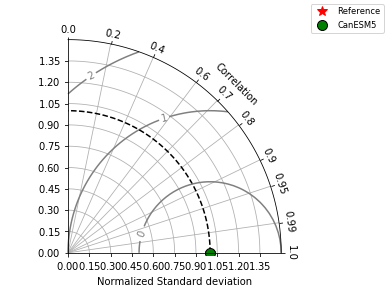

In [117]:
# Reference options 
ref_std = 1
ref_color = 'r'
ref_label = 'Reference'

# Samples list (maybe make a dictionary)
# -----------------------------------
#         std   rho   model  color
# -----------------------------------
samples = [[stats_dict['corr'], stats_dict['std_norm'], stats_dict['model'], 'g']]

#===============================
# Generate Taylor Diagram
#===============================
fig = plt.figure()

# generate Taylor diagram object 
dia = TaylorDiagram(refstd=ref_std, label=ref_label, extend=False, fig=fig)

# mark reference point as a red star
dia.samplePoints[0].set_color(ref_color)  

# add models to Taylor diagram
for i, (stddev, corrcoef, name, col) in enumerate(samples):
    dia.add_sample(stddev, corrcoef,
                   marker='o', ms=10, ls='',
                   mfc=col, mec='k',
                   label=name)

#===============================
# RMSE contours 
# Levels : number RMSE lines 
# color  : color of contours gray
#===============================
# Add RMS contours, and label them
contours = dia.add_contours(levels=3, colors='0.5') 

# add labelto RMSE contours 
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

# Add grid lines 
dia.add_grid()                              

# Put ticks outward
dia._ax.axis[:].major_ticks.set_tick_out(True)  

# Add a figure legend and title
fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           numpoints=1, prop=dict(size='small'), loc='upper right')

# Section difference

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)



minvalue_conc,maxvalue_conc,cmap,nsteps,labelstep,cfactor = cprops[ovar.name]

cstep = abs(minvalue_conc-maxvalue_conc)/nsteps

cbarstep = abs(minvalue_conc-maxvalue_conc)/(nsteps/4);

contour_levs = np.arange(minvalue_conc,maxvalue_conc+cstep,cstep)

contour_labels = np.arange(minvalue_conc,maxvalue_conc+cstep,labelstep)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.dpi=300
fig.set_figheight(4)
fig.set_figwidth(2.5)
ax1.set_title(f'{section.long_name}',fontsize=5)
cax = ax1.contourf(section.station,section.depth,section.T*cfactor,levels=contour_levs,extend='both',cmap=cmap)
ax2.contourf(section.station,section.depth,section.T*1e3,levels=contour_levs,extend='both',cmap=cmap)

cs1 = ax1.contour(section.station,section.depth,section.T*cfactor,levels=contour_levs,
                  extend='both',
                  colors='0.6',
                  linewidths=0.2)
ax1.clabel(cs1,fontsize=4,fmt='%1.f')

cs2 = ax2.contour(section.station,section.depth,section.T*cfactor,
                  levels=contour_levs,extend='both',
                  colors='0.6',
                  linewidths=0.2)
ax2.clabel(cs2,fontsize=4, fmt='%1.f')

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.5)
    ax2.spines[axis].set_linewidth(0.5)
    
ax1.tick_params(which='both', width=0.5)
ax2.tick_params(which='both', width=0.5)

ax1.set_facecolor('k')
ax2.set_facecolor('k')
ax1.set_ylim(1000,0)
ax2.set_ylim(6000,1000)

cbar_ax = fig.add_axes([0.95, 0.2, 0.04, 0.6])
cbar = fig.colorbar(cax, cax=cbar_ax,extend='both')
cbar.ax.tick_params(labelsize=5)
cbar.ax.tick_params(which='both', width=0.5)
cbar.outline.set_linewidth(0.5)

# Old pieces of code

In [ ]:
# load station information from csv file
#df = pd.read_csv('../qc/GLODAPv2.2019_COORDS.csv')

#df = df.dropna()
#df = df.reset_index().drop('Unnamed: 0',axis=1)

#df_obs = pd.read_csv('../data/GLODAPv2.2019_Merged_Master_File.csv')

#df_obs.head()


# Model
#url = "../catalogs/pangeo-cmip6.json"
#col = intake.open_esm_datastore(url)
#col

#cat = col.search(experiment_id=['historical'], 
#                 table_id='Omon', 
#                 variable_id='dissic',
#                 grid_label='gn')
#cat.df

#dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
#                                cdf_kwargs={'chunks': {}, 'decode_times': False})

#ds = dset_dict['CMIP.CCCma.CanESM5.historical.Omon.gn']

#ds['dissic'].squeeze().isel(lev=0).std('time')

In [ ]:
from easy_coloc import lib_easy_coloc
import xarray as xr
import pandas as pd
import cartopy as cart
import matplotlib.pylab as plt
from matplotlib import cm
import datetime
import cmocean
import numpy as np
import dateutil
import intake
import dask

def model_to_line(ovar_name=None, 
                            model=None, 
                            cruise_line=None,
                            catalog_path='../catalogs/pangeo-cmip6.json',
                            qc_path='../qc'):
    '''
    generate_model_section(ovar_name, model)
    
    Input
    ==========
    ovar_name : variable name (eg 'dissic')
    model : model name (eg CanESM5)
    
    Output
    ===========
    ds : dataset of section output
    '''
    institue = {'CanESM5':'CCCma',
                'CNRM-ESM2-1':'CNRM-CERFACS',
                'IPSL-CM6A-LR':'IPSL',
                'MIROC-ES2L':'MIROC',
                'UKESM1-0-LL':'MOHC',
                'GISS-E2-1-G-CC':'NASA-GISS',
                'GISS-E2-1-G':'NASA-GISS'
               }

    # Get CMIP6 output from intake_esm
    col = intake.open_esm_datastore(catalog_path)
    cat = col.search(experiment_id='historical', 
                     table_id='Omon', 
                     variable_id=ovar_name, 
                     grid_label='gn')

    # dictionary of subset data
    dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                    cdf_kwargs={'chunks': {}})

    # Put data into dataset
    ds = dset_dict[f'CMIP.{institue[model]}.{model}.historical.Omon.gn']

    
    # Rename olevel to lev 
    coord_dict = {'olevel':'lev'} # a dictionary for converting coordinate names
    if 'olevel' in ds.dims:
        ds = ds.rename(coord_dict)

    # load GLODAP station information from csv file
    # drop nans, reset index, and drop uneeded variable
    df = pd.read_csv(f'{qc_path}/GLODAPv2.2019_COORDS.csv')
    df = df.dropna()
    df = df.reset_index().drop('Unnamed: 0', axis=1)

    # Genearte times list and put into dataframe
    times = [f'{int(year)}-{int(month):02d}-01' for year,month in zip(df.year,df.month)]
    df['dates'] = times 

    # Find unique dates, these are the sample dates
    sample_dates = df['dates'].sort_values().unique()
    
    # Parse the historical period
    sample_dates = sample_dates[0:125]
    sample_dates = [dateutil.parser.parse(date) for date in sample_dates]

    # ==========================================
    # Here we start making the ovar dataset
    # ==========================================
    # Trim the dates to sample_dates
    ovar = ds[ovar_name].sel(time=sample_dates)
    ovar['lat'] = ds.latitude
    ovar['lon'] = ds.longitude

    # create source grid and target section objects
    # this requires lon,lat from stations and the source grid dataset containing lon,lat
    proj = lib_easy_coloc.projection(df['longitude'].values,df['latitude'].values,grid=ovar,
                                     from_global=True)

    # 4-D max for easy_coloc. Not entirely sure what we are squeezing out?
    ovar = ovar.squeeze() 

    # run the projection on the WOA analyzed temperature (t_an)
    fld = np.zeros((len(sample_dates),len(ovar.lev),len(df)))

    # placeholder so code runs without crashing
    # Raf can maybe fix this?
    for ind in range(5, 130, 5):
        dates = sample_dates[ind-5:ind]
        fld_tem = proj.run(ovar.sel(time=dates)[:])
        fld[ind-5:ind,:,:] = fld_tem


    # create datarray with sampling information
    sampled_var = xr.DataArray(fld,
                               dims=['time','lev','all_stations'],
                               coords={'time':ovar['time'],
                                       'lev':ovar['lev'],
                                       'all_stations':df.index.values,
                                       'dx':('all_stations',df.dx.values),
                                       'bearing':('all_stations',df.bearing.values),
                                       'lat':('all_stations',df.latitude.values),
                                       'lon':('all_stations',df.longitude.values),
                                      },
                               attrs={'units':ovar.units,
                                      'long_name':ovar.long_name
                                     }
                              )

    # Glodap expo codes
    expc = pd.read_csv(f'{qc_path}/FILTERED_GLODAP_EXPOCODE.csv')

    # dates
    dates = [f'{int(year)}-{int(month):02d}' for year,month in zip(df.year, df.month)]
    df.dates = dates 
    
    # rename df to coords
    cruise_x = df[df.cruise.isin( expc['ID'][expc.LINE.str.contains(cruise_line )] )]

    # need to change the Timedelta each day for some reason
    section_dates = [dateutil.parser.parse(date) - pd.Timedelta(np.timedelta64(14, 'D')) for date in cruise_x.dates]
    
    section_dates = xr.DataArray(section_dates,dims='station')

    stations = cruise_x.index
    stations = xr.DataArray(stations,dims='station')

    section = sampled_var.sel(all_stations = stations, time=section_dates)
    section.attrs['expocode'] = expc[expc.ID == cruise_id].EXPOCODE.values[0]
    section.name = ovar.name
    
    
    #section.to_netcdf(f'../../../sections/{ovar.name}_{model}_{realization}_{section.expocode}.nc')


    # convert datarray to dataset
    # This grabs everything
    #ds = sampled_var.to_dataset(name=ovar.name)

    return section

In [ ]:
#for cruisexpc['EXPOCODE'][expc.LINE.str.contains(cruise_line)]

# Gets expocodes for p16 line    
expc = pd.read_csv(f'../qc/FILTERED_GLODAP_EXPOCODE.csv')
expc['EXPOCODE'][expc.LINE.str.contains('P16')]


# This is broken?
cruise_line='A16'
for cruise_id in expc['EXPOCODE'][expc.LINE.str.contains(cruise_line)]: 
    cruise_x = df[df.cruise==cruise_id]
    print(cruise_x)